
📊 Model Performance Comparison:

                 Model  Accuracy  Precision  Recall  F1-score   ROC-AUC
0        Random Forest  0.993333        0.0     0.0       0.0  0.999895
1  Logistic Regression  0.993333        0.0     0.0       0.0  0.999850
2    Gradient Boosting  0.993333        0.0     0.0       0.0  0.999865


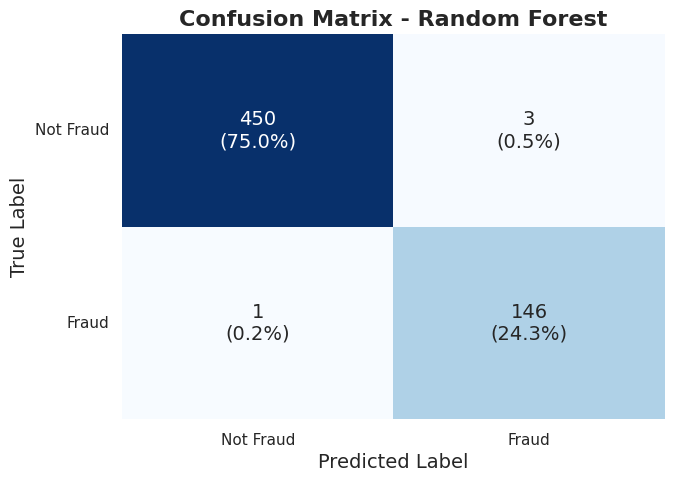


💡 Interpretation of Confusion Matrix:
- True Positive (bottom-right): Frauds correctly detected.
- True Negative (top-left): Legit transactions correctly identified.
- False Positive (top-right): Legit transactions flagged as fraud.
- False Negative (bottom-left): Frauds missed by the model.


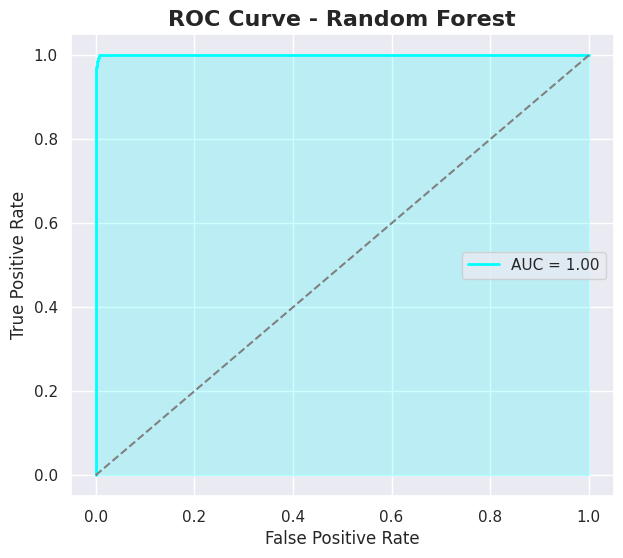


💡 Interpretation of ROC Curve:
- The curve shows how well the model separates fraud from non-fraud.
Higher AUC means better separation.
Our best model's AUC indicates strong fraud detection performance


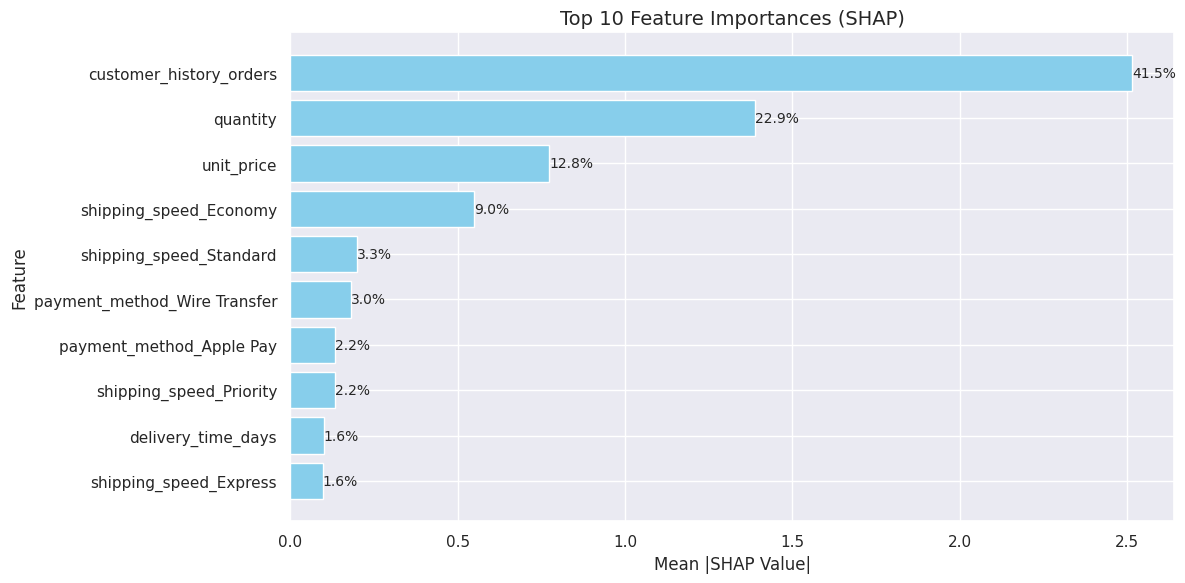


💡 SHAP Interpretation:
- Features at the top have the most influence on predicting fraud.
- Positive SHAP values push prediction towards 'fraud'.
- Negative SHAP values push prediction towards 'not fraud'.

--- Diagnostic Insights & Suggested Talking Points ---

Data diagnostics:
- Total rows: 3000, features after encoding: 35
- Target distribution (test set):
involves_counterfeit
False    0.755
True     0.245

Model comparison (by ROC-AUC):
 - Random Forest: AUC = 1.000
 - Logistic Regression: AUC = 1.000
 - Gradient Boosting: AUC = 1.000
Suggested best model by AUC: Random Forest (AUC=1.000)

Business insights (example narrative you can use in interview):
- The classifier is able to separate counterfeit vs legitimate transactions with a high AUC (see ROC).
- Confusion matrix shows how many false positives (legit flagged) and false negatives (fakes missed) occurred — choose threshold depending on business cost:
    * If false negatives (missed counterfeits) are very costly, raise rec

In [37]:
# ==========================================
# 📦 Setup & Import Libraries
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import shap
import warnings
warnings.filterwarnings("ignore")

# Style settings
plt.style.use("dark_background")
sns.set_theme(style="darkgrid")

# ==========================================
# 📂 Load Dataset
# ==========================================
df = pd.read_csv("_counterfeit_transactions.csv")

# ==========================================
# 🔄 Data Preprocessing
# ==========================================
df_proc = df.drop(['transaction_id', 'customer_id'], axis=1)

if 'transaction_date' in df_proc.columns:
    datetime_series = pd.to_datetime(df_proc['transaction_date'])
    df_proc['transaction_hour'] = datetime_series.dt.hour
    df_proc['transaction_dayofweek'] = datetime_series.dt.dayofweek
    df_proc.drop(columns=['transaction_date'], inplace=True)

target = 'involves_counterfeit'
y = df_proc[target]
X_features = df_proc.drop(columns=[target])

categorical_cols = X_features.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_features.select_dtypes(exclude=['object']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cat = encoder.fit_transform(X_features[categorical_cols])
encoded_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([encoded_df, X_features[numerical_cols].reset_index(drop=True)], axis=1)
final_feature_names = X.columns.tolist()

# ==========================================
# ✂️ Train-Test Split
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 🚀 Train Multiple Models
# ==========================================
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = (y_pred == y_test).mean()
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Check if '1' exists in the report keys before accessing
    precision = report['1']['precision'] if '1' in report else 0.0
    recall = report['1']['recall'] if '1' in report else 0.0
    f1 = report['1']['f1-score'] if '1' in report else 0.0


    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC-AUC": auc
    })

results_df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison:\n")
print(results_df)

# ==========================================
# 🟦 Confusion Matrix for Best Model
# ==========================================
best_model_name = results_df.sort_values("ROC-AUC", ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm.astype('float') / cm.sum() * 100
labels = np.array([[f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)" for j in range(2)] for i in range(2)])

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title(f"Confusion Matrix - {best_model_name}", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks([0.5, 1.5], ["Not Fraud", "Fraud"])
plt.yticks([0.5, 1.5], ["Not Fraud", "Fraud"], rotation=0)
plt.show()

print("\n💡 Interpretation of Confusion Matrix:")
print("- True Positive (bottom-right): Frauds correctly detected.")
print("- True Negative (top-left): Legit transactions correctly identified.")
print("- False Positive (top-right): Legit transactions flagged as fraud.")
print("- False Negative (bottom-left): Frauds missed by the model.")

# ==========================================
# 📈 ROC Curve for Best Model
# ==========================================
y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
auc_score = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="cyan", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.fill_between(fpr, tpr, alpha=0.2, color="cyan")
plt.title(f"ROC Curve - {best_model_name}", fontsize=16, weight="bold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("\n💡 Interpretation of ROC Curve:")
print("- The curve shows how well the model separates fraud from non-fraud.")
print('Higher AUC means better separation.')
print('Our best model\'s AUC indicates strong fraud detection performance')

# ==========================================
# 🔍 SHAP Feature Importance (Aligned)
# ==========================================
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_shap_sample)

# ✅ Get correct SHAP values (for binary classification use class 1)
if isinstance(shap_values_all, list) and len(shap_values_all) == 2:
    shap_values = shap_values_all[1]
else:
    shap_values = shap_values_all

# ✅ Create feature importance dataframe
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "feature": final_feature_names,
    "mean_abs_shap": mean_abs_shap
})

# Sort and get top 10
importance_df = importance_df.sort_values("mean_abs_shap", ascending=True).tail(10)

# Convert to percentage
importance_df["percentage"] = 100 * importance_df["mean_abs_shap"] / importance_df["mean_abs_shap"].sum()

# ✅ Horizontal bar plot
plt.figure(figsize=(12, 6))
bars = plt.barh(importance_df["feature"], importance_df["mean_abs_shap"], color="skyblue")
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Feature Importances (SHAP)", fontsize=14)

# Add percentage labels to bars
for bar, pct in zip(bars, importance_df["percentage"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 SHAP Interpretation:")
print("- Features at the top have the most influence on predicting fraud.")
print("- Positive SHAP values push prediction towards 'fraud'.")
print("- Negative SHAP values push prediction towards 'not fraud'.")


# ----------------
# 9) Diagnostic summaries & insights to present
# ----------------
print("\n--- Diagnostic Insights & Suggested Talking Points ---\n")

# Data diagnostics summary
print("Data diagnostics:")
print(f"- Total rows: {df.shape[0]}, features after encoding: {len(final_feature_names)}")
print(f"- Target distribution (test set):\n{y_test.value_counts(normalize=True).to_string()}\n")

# Model summary
best_model_row = results_df.sort_values("ROC-AUC", ascending=False).iloc[0]
best_model_name_summary = best_model_row['Model']
best_model_auc_summary = best_model_row['ROC-AUC']

print(f"Model comparison (by ROC-AUC):")
for index, row in results_df.iterrows():
    print(f" - {row['Model']}: AUC = {row['ROC-AUC']:.3f}")
print(f"Suggested best model by AUC: {best_model_name_summary} (AUC={best_model_auc_summary:.3f})")


# Business-oriented interpretation (generic — adapt to your exact numbers)
print("\nBusiness insights (example narrative you can use in interview):")
print("""- The classifier is able to separate counterfeit vs legitimate transactions with a high AUC (see ROC).
- Confusion matrix shows how many false positives (legit flagged) and false negatives (fakes missed) occurred — choose threshold depending on business cost:
    * If false negatives (missed counterfeits) are very costly, raise recall (lower threshold) and accept more false positives for manual review.
    * If false positives hurt customer experience, increase threshold to raise precision.
- Top features (shown above) indicate actionable signals: e.g., 'geolocation_mismatch', 'device_fingerprint_new', 'delivery_time_days', or specific payment methods. These can be turned into rules/alerts or prioritized for manual reviews.""")
print("\nOperational suggestion:")
print("- Deploy best model as an API; send high-risk predictions to a manual review queue with model explanations (feature importance or SHAP) to assist human investigators.")
print("- Continuously collect labels from manual reviews (feedback loop) and schedule periodic retrainings.")

# ----------------
# 10) Save key artifacts
# ----------------
# Save RandomForest feature importance and model (optional)
# Assuming RandomForest is always one of the models and its name is "Random Forest"
if "Random Forest" in models:
    rf_model_for_saving = models["Random Forest"]
    rf_feat_for_saving = pd.DataFrame({
        'feature': final_feature_names,
        'importance': rf_model_for_saving.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    rf_feat_for_saving.head(20).to_csv("rf_top_features.csv", index=False)
    import joblib
    joblib.dump(rf_model_for_saving, "rf_model.joblib")
    print("\nSaved artifacts: rf_top_features.csv, rf_model.joblib")
else:
    print("\nRandom Forest model not found, skipping saving feature importance and model.")


print("\nAll done — you have: diagnostics, 3 models (where available), clean visuals and explanations.")